In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.7.0


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
IMAGE_SIZE = 128
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "Images/"

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "US images/*")))
    masks = sorted(glob(os.path.join(path, "Expert mask images/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  880
Validation data:  110
Testing data:  110


In [9]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

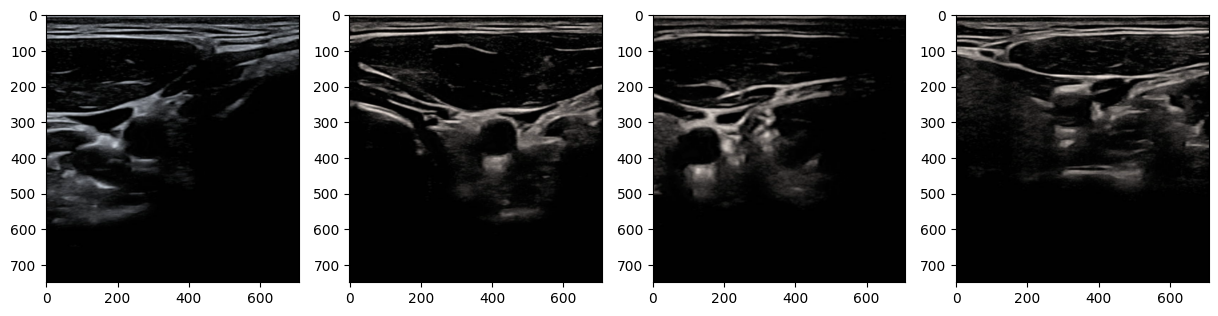

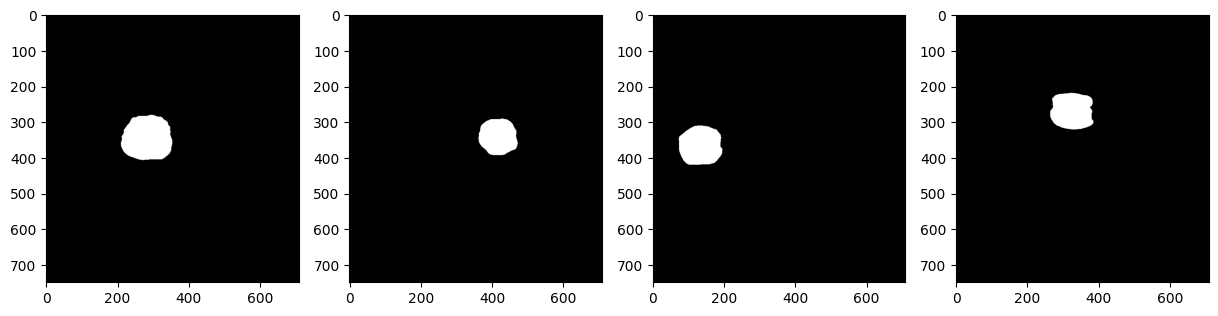

In [10]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [11]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [12]:
    model = model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']           

In [13]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [14]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [15]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [16]:
filepath = 'C:\\Users\\NAGARAJ K\\Project-M'

In [17]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [18]:
callbacks = [
    checkpoint,
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [19]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
) 

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.8539 - dice_coef: 0.1461 - recall: 0.9228 - precision: 0.2822
Epoch 00001: val_loss improved from inf to 0.93091, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 104s 807ms/step - loss: 0.8539 - dice_coef: 0.1461 - recall: 0.9228 - precision: 0.2822 - val_loss: 0.9309 - val_dice_coef: 0.0691 - val_recall: 0.3784 - val_precision: 0.9471 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.7619 - dice_coef: 0.2381 - recall: 0.9939 - precision: 0.7156
Epoch 00002: val_loss improved from 0.93091 to 0.87392, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 89s 809ms/step - loss: 0.7619 - dice_coef: 0.2381 - recall: 0.9939 - precision: 0.7156 - val_loss: 0.8739 - val_dice_coef: 0.1260 - val_recall: 0.6359 - val_precision: 0.9310 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.7119 - dice_coef: 0.2881 - recall: 0.9939 - precision: 0.8178
Epoch 00003: val_loss improved from 0.87392 to 0.79602, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 92s 840ms/step - loss: 0.7119 - dice_coef: 0.2881 - recall: 0.9939 - precision: 0.8178 - val_loss: 0.7960 - val_dice_coef: 0.2037 - val_recall: 0.7086 - val_precision: 0.9064 - lr: 1.0000e-04
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 0.6741 - dice_coef: 0.3259 - recall: 0.9933 - precision: 0.8593
Epoch 00004: val_loss improved from 0.79602 to 0.74028, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 98s 893ms/step - loss: 0.6741 - dice_coef: 0.3259 - recall: 0.9933 - precision: 0.8593 - val_loss: 0.7403 - val_dice_coef: 0.2593 - val_recall: 0.7377 - val_precision: 0.9159 - lr: 1.0000e-04
Epoch 5/30
110/110 [==============================] - ETA: 0s - loss: 0.6368 - dice_coef: 0.3632 - recall: 0.9921 - precision: 0.8843
Epoch 00005: val_loss improved from 0.74028 to 0.69349, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 113s 1s/step - loss: 0.6368 - dice_coef: 0.3632 - recall: 0.9921 - precision: 0.8843 - val_loss: 0.6935 - val_dice_coef: 0.3061 - val_recall: 0.7571 - val_precision: 0.9238 - lr: 1.0000e-04
Epoch 6/30
110/110 [==============================] - ETA: 0s - loss: 0.5981 - dice_coef: 0.4019 - recall: 0.9911 - precision: 0.9034
Epoch 00006: val_loss improved from 0.69349 to 0.65234, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 119s 1s/step - loss: 0.5981 - dice_coef: 0.4019 - recall: 0.9911 - precision: 0.9034 - val_loss: 0.6523 - val_dice_coef: 0.3472 - val_recall: 0.7603 - val_precision: 0.9303 - lr: 1.0000e-04
Epoch 7/30
110/110 [==============================] - ETA: 0s - loss: 0.5577 - dice_coef: 0.4423 - recall: 0.9897 - precision: 0.9192
Epoch 00007: val_loss improved from 0.65234 to 0.61863, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 121s 1s/step - loss: 0.5577 - dice_coef: 0.4423 - recall: 0.9897 - precision: 0.9192 - val_loss: 0.6186 - val_dice_coef: 0.3809 - val_recall: 0.7454 - val_precision: 0.9420 - lr: 1.0000e-04
Epoch 8/30
110/110 [==============================] - ETA: 0s - loss: 0.5166 - dice_coef: 0.4834 - recall: 0.9880 - precision: 0.9303
Epoch 00008: val_loss improved from 0.61863 to 0.56360, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 148s 1s/step - loss: 0.5166 - dice_coef: 0.4834 - recall: 0.9880 - precision: 0.9303 - val_loss: 0.5636 - val_dice_coef: 0.4359 - val_recall: 0.7825 - val_precision: 0.9307 - lr: 1.0000e-04
Epoch 9/30
110/110 [==============================] - ETA: 0s - loss: 0.4755 - dice_coef: 0.5245 - recall: 0.9859 - precision: 0.9382
Epoch 00009: val_loss improved from 0.56360 to 0.51650, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 286s 3s/step - loss: 0.4755 - dice_coef: 0.5245 - recall: 0.9859 - precision: 0.9382 - val_loss: 0.5165 - val_dice_coef: 0.4832 - val_recall: 0.7990 - val_precision: 0.9509 - lr: 1.0000e-04
Epoch 10/30
110/110 [==============================] - ETA: 0s - loss: 0.4349 - dice_coef: 0.5651 - recall: 0.9837 - precision: 0.9463
Epoch 00010: val_loss improved from 0.51650 to 0.47735, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 130s 1s/step - loss: 0.4349 - dice_coef: 0.5651 - recall: 0.9837 - precision: 0.9463 - val_loss: 0.4773 - val_dice_coef: 0.5223 - val_recall: 0.8079 - val_precision: 0.9496 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 11/30
110/110 [==============================] - ETA: 0s - loss: 0.3956 - dice_coef: 0.6044 - recall: 0.9824 - precision: 0.9527
Epoch 00011: val_loss improved from 0.47735 to 0.44213, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 121s 1s/step - loss: 0.3956 - dice_coef: 0.6044 - recall: 0.9824 - precision: 0.9527 - val_loss: 0.4421 - val_dice_coef: 0.5578 - val_recall: 0.8183 - val_precision: 0.9269 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.3584 - dice_coef: 0.6416 - recall: 0.9814 - precision: 0.9581
Epoch 00012: val_loss improved from 0.44213 to 0.39721, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 129s 1s/step - loss: 0.3584 - dice_coef: 0.6416 - recall: 0.9814 - precision: 0.9581 - val_loss: 0.3972 - val_dice_coef: 0.6024 - val_recall: 0.8329 - val_precision: 0.9501 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 13/30
110/110 [==============================] - ETA: 0s - loss: 0.3236 - dice_coef: 0.6764 - recall: 0.9807 - precision: 0.9631
Epoch 00013: val_loss improved from 0.39721 to 0.36323, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 113s 1s/step - loss: 0.3236 - dice_coef: 0.6764 - recall: 0.9807 - precision: 0.9631 - val_loss: 0.3632 - val_dice_coef: 0.6364 - val_recall: 0.8463 - val_precision: 0.9415 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.2915 - dice_coef: 0.7085 - recall: 0.9799 - precision: 0.9676
Epoch 00014: val_loss did not improve from 0.36323
110/110 [==============================] - 91s 826ms/step - loss: 0.2915 - dice_coef: 0.7085 - recall: 0.9799 - precision: 0.9676 - val_loss: 0.3744 - val_dice_coef: 0.6250 - val_recall: 0.7522 - val_precision: 0.9785 - lr: 1.0000e-04
Epoch 15/30
110/110 [==============================] - ETA: 0s - loss: 0.2627 - dice_coef: 0.7373 - recall: 0.9787 - precision: 0.9709
Epoch 00015: val_loss improved from 0.36323 to 0.31648, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 105s 951ms/step - loss: 0.2627 - dice_coef: 0.7373 - recall: 0.9787 - precision: 0.9709 - val_loss: 0.3165 - val_dice_coef: 0.6830 - val_recall: 0.8306 - val_precision: 0.9502 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 16/30
110/110 [==============================] - ETA: 0s - loss: 0.2371 - dice_coef: 0.7629 - recall: 0.9778 - precision: 0.9728
Epoch 00016: val_loss improved from 0.31648 to 0.28940, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 111s 1s/step - loss: 0.2371 - dice_coef: 0.7629 - recall: 0.9778 - precision: 0.9728 - val_loss: 0.2894 - val_dice_coef: 0.7100 - val_recall: 0.8432 - val_precision: 0.9461 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 17/30
110/110 [==============================] - ETA: 0s - loss: 0.2138 - dice_coef: 0.7862 - recall: 0.9774 - precision: 0.9753
Epoch 00017: val_loss improved from 0.28940 to 0.26582, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 108s 981ms/step - loss: 0.2138 - dice_coef: 0.7862 - recall: 0.9774 - precision: 0.9753 - val_loss: 0.2658 - val_dice_coef: 0.7334 - val_recall: 0.8362 - val_precision: 0.9683 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 18/30
110/110 [==============================] - ETA: 0s - loss: 0.1931 - dice_coef: 0.8069 - recall: 0.9770 - precision: 0.9773
Epoch 00018: val_loss improved from 0.26582 to 0.25094, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 125s 1s/step - loss: 0.1931 - dice_coef: 0.8069 - recall: 0.9770 - precision: 0.9773 - val_loss: 0.2509 - val_dice_coef: 0.7484 - val_recall: 0.8281 - val_precision: 0.9729 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 19/30
110/110 [==============================] - ETA: 0s - loss: 0.1742 - dice_coef: 0.8258 - recall: 0.9772 - precision: 0.9801
Epoch 00019: val_loss improved from 0.25094 to 0.23287, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 136s 1s/step - loss: 0.1742 - dice_coef: 0.8258 - recall: 0.9772 - precision: 0.9801 - val_loss: 0.2329 - val_dice_coef: 0.7664 - val_recall: 0.8333 - val_precision: 0.9724 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 20/30
110/110 [==============================] - ETA: 0s - loss: 0.1580 - dice_coef: 0.8420 - recall: 0.9764 - precision: 0.9816
Epoch 00020: val_loss improved from 0.23287 to 0.20999, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 123s 1s/step - loss: 0.1580 - dice_coef: 0.8420 - recall: 0.9764 - precision: 0.9816 - val_loss: 0.2100 - val_dice_coef: 0.7893 - val_recall: 0.8609 - val_precision: 0.9597 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 21/30
110/110 [==============================] - ETA: 0s - loss: 0.1439 - dice_coef: 0.8561 - recall: 0.9765 - precision: 0.9824
Epoch 00021: val_loss improved from 0.20999 to 0.20084, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 114s 1s/step - loss: 0.1439 - dice_coef: 0.8561 - recall: 0.9765 - precision: 0.9824 - val_loss: 0.2008 - val_dice_coef: 0.7984 - val_recall: 0.8494 - val_precision: 0.9689 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 22/30
110/110 [==============================] - ETA: 0s - loss: 0.1311 - dice_coef: 0.8689 - recall: 0.9763 - precision: 0.9839
Epoch 00022: val_loss improved from 0.20084 to 0.19615, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 112s 1s/step - loss: 0.1311 - dice_coef: 0.8689 - recall: 0.9763 - precision: 0.9839 - val_loss: 0.1962 - val_dice_coef: 0.8030 - val_recall: 0.8289 - val_precision: 0.9789 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 23/30
110/110 [==============================] - ETA: 0s - loss: 0.1199 - dice_coef: 0.8801 - recall: 0.9759 - precision: 0.9847
Epoch 00023: val_loss improved from 0.19615 to 0.17822, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 114s 1s/step - loss: 0.1199 - dice_coef: 0.8801 - recall: 0.9759 - precision: 0.9847 - val_loss: 0.1782 - val_dice_coef: 0.8212 - val_recall: 0.8532 - val_precision: 0.9688 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.1097 - dice_coef: 0.8903 - recall: 0.9762 - precision: 0.9858
Epoch 00024: val_loss improved from 0.17822 to 0.16856, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 111s 1s/step - loss: 0.1097 - dice_coef: 0.8903 - recall: 0.9762 - precision: 0.9858 - val_loss: 0.1686 - val_dice_coef: 0.8309 - val_recall: 0.8574 - val_precision: 0.9661 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.1007 - dice_coef: 0.8993 - recall: 0.9762 - precision: 0.9866
Epoch 00025: val_loss improved from 0.16856 to 0.15854, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 118s 1s/step - loss: 0.1007 - dice_coef: 0.8993 - recall: 0.9762 - precision: 0.9866 - val_loss: 0.1585 - val_dice_coef: 0.8407 - val_recall: 0.8579 - val_precision: 0.9720 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0931 - dice_coef: 0.9069 - recall: 0.9760 - precision: 0.9871
Epoch 00026: val_loss improved from 0.15854 to 0.14767, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 127s 1s/step - loss: 0.0931 - dice_coef: 0.9069 - recall: 0.9760 - precision: 0.9871 - val_loss: 0.1477 - val_dice_coef: 0.8520 - val_recall: 0.8637 - val_precision: 0.9741 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0864 - dice_coef: 0.9136 - recall: 0.9754 - precision: 0.9873
Epoch 00027: val_loss improved from 0.14767 to 0.14578, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 121s 1s/step - loss: 0.0864 - dice_coef: 0.9136 - recall: 0.9754 - precision: 0.9873 - val_loss: 0.1458 - val_dice_coef: 0.8538 - val_recall: 0.8535 - val_precision: 0.9752 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 28/30
110/110 [==============================] - ETA: 0s - loss: 0.0795 - dice_coef: 0.9205 - recall: 0.9759 - precision: 0.9886
Epoch 00028: val_loss improved from 0.14578 to 0.13112, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 115s 1s/step - loss: 0.0795 - dice_coef: 0.9205 - recall: 0.9759 - precision: 0.9886 - val_loss: 0.1311 - val_dice_coef: 0.8688 - val_recall: 0.8747 - val_precision: 0.9726 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 29/30
110/110 [==============================] - ETA: 0s - loss: 0.0739 - dice_coef: 0.9261 - recall: 0.9763 - precision: 0.9889
Epoch 00029: val_loss improved from 0.13112 to 0.12748, saving model to C:\Users\NAGARAJ K\Project-M
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\Project-M\assets
110/110 [==============================] - 111s 1s/step - loss: 0.0739 - dice_coef: 0.9261 - recall: 0.9763 - precision: 0.9889 - val_loss: 0.1275 - val_dice_coef: 0.8722 - val_recall: 0.8742 - val_precision: 0.9695 - lr: 1.0000e-04


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.0686 - dice_coef: 0.9314 - recall: 0.9762 - precision: 0.9895
Epoch 00030: val_loss did not improve from 0.12748
110/110 [==============================] - 101s 921ms/step - loss: 0.0686 - dice_coef: 0.9314 - recall: 0.9762 - precision: 0.9895 - val_loss: 0.1315 - val_dice_coef: 0.8683 - val_recall: 0.8516 - val_precision: 0.9789 - lr: 1.0000e-04


In [20]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

14/14 [==============================] - 3s 226ms/step - loss: 0.1165 - dice_coef: 0.8838 - recall: 0.8789 - precision: 0.9816


[0.11645133048295975,
 0.8837522864341736,
 0.8788672685623169,
 0.9815731644630432]

In [21]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [22]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

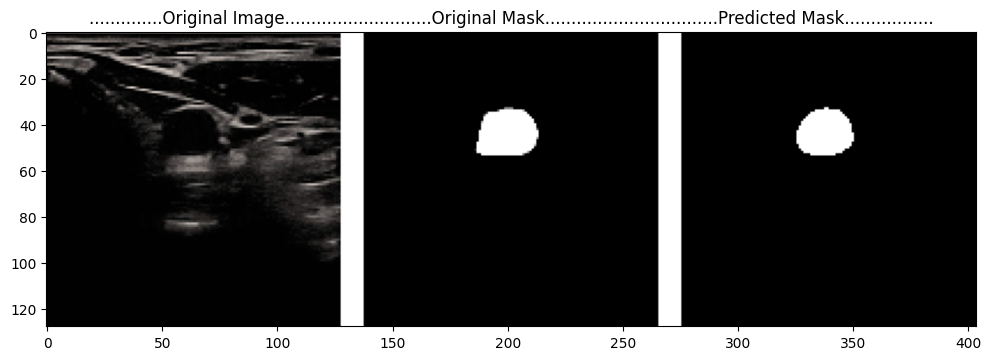

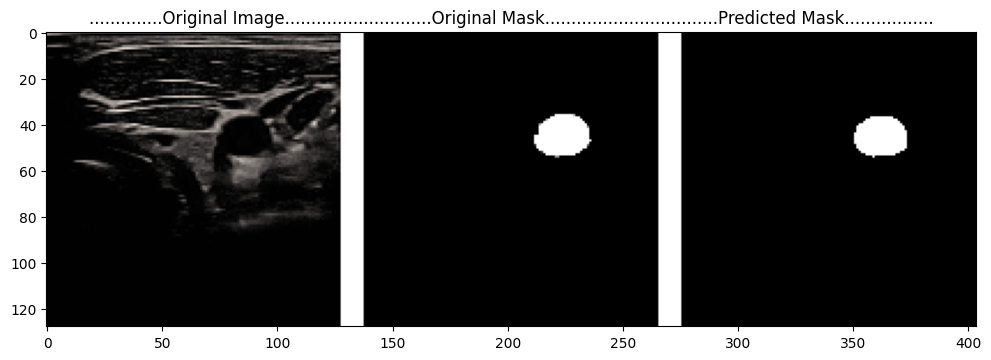

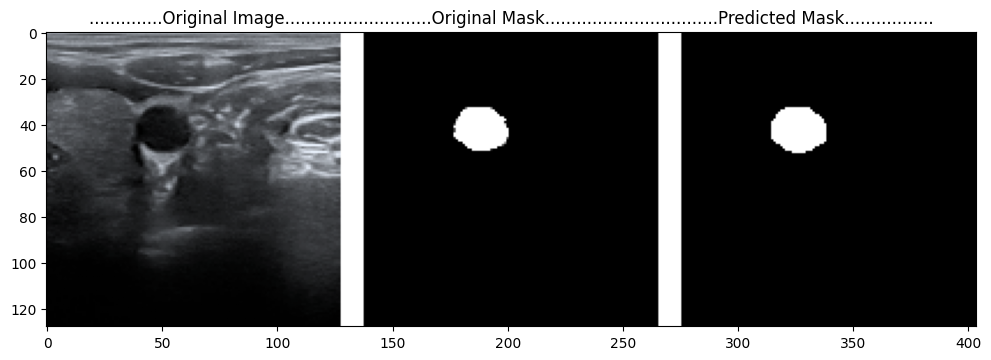

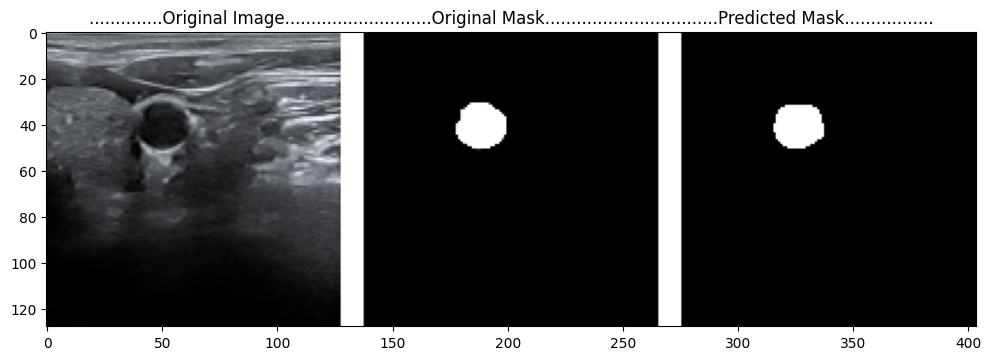

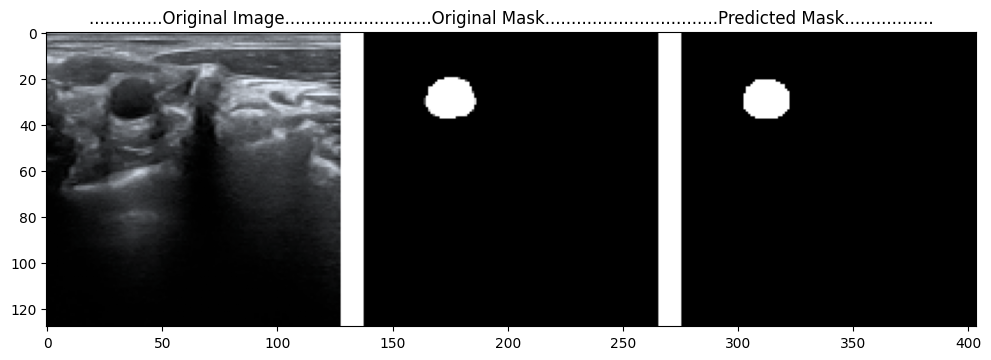

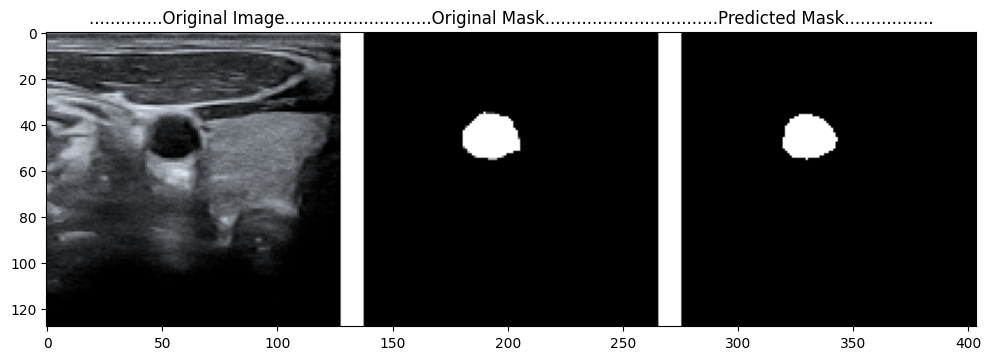

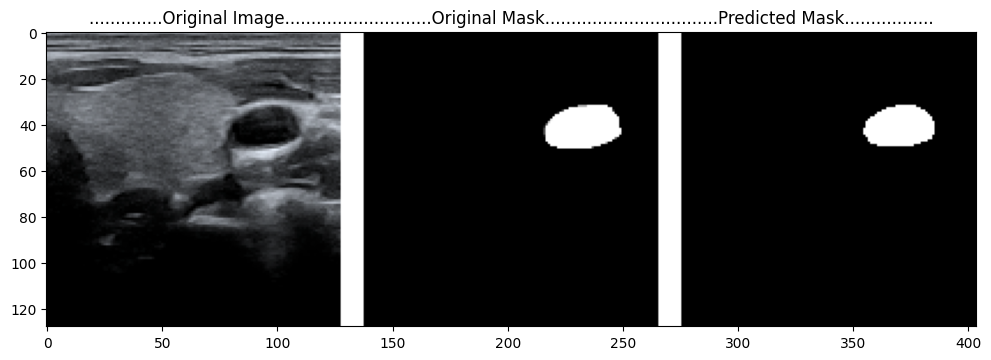

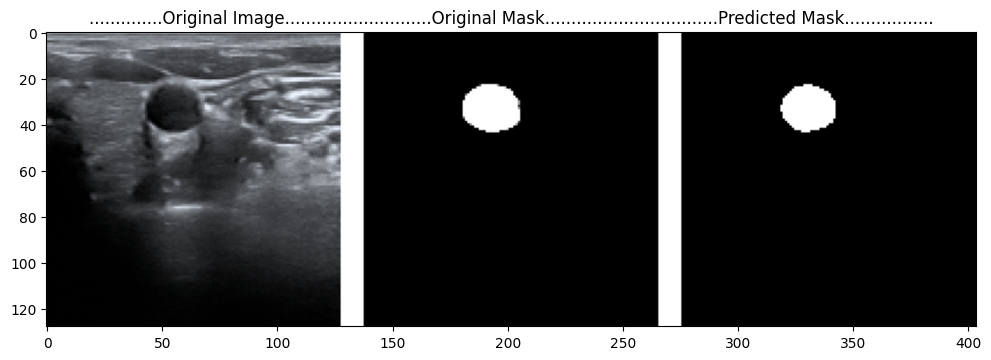

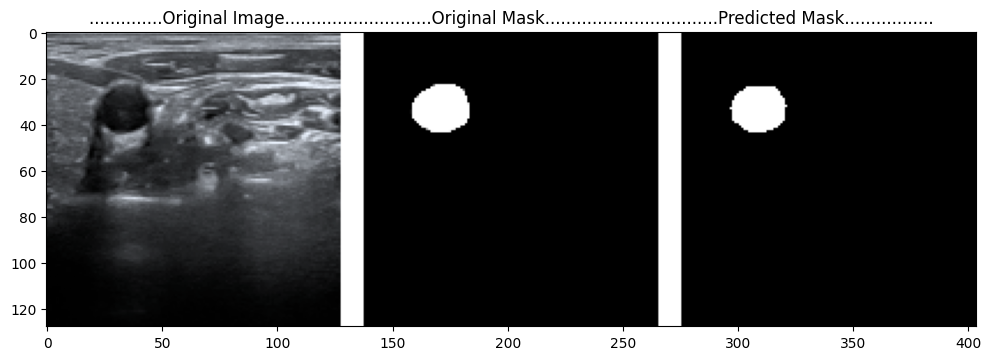

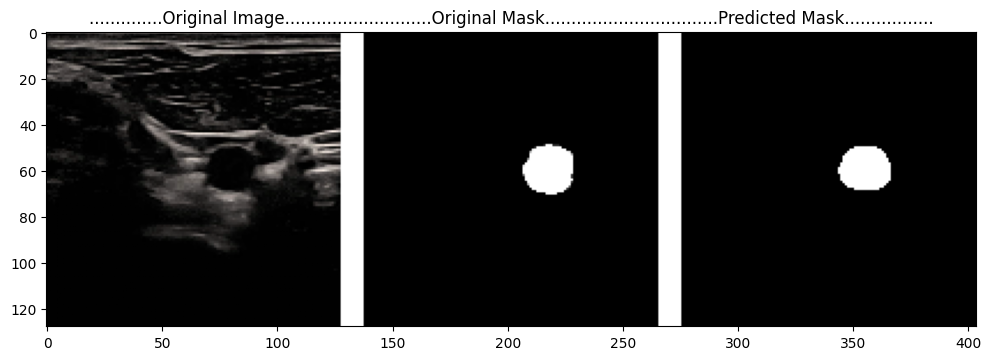

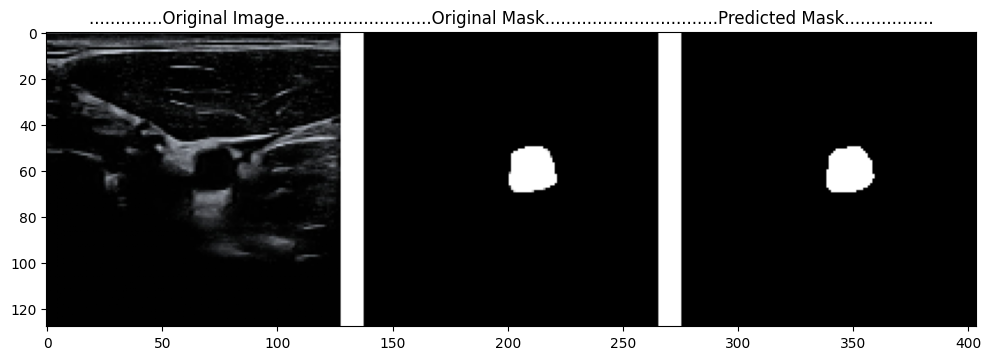

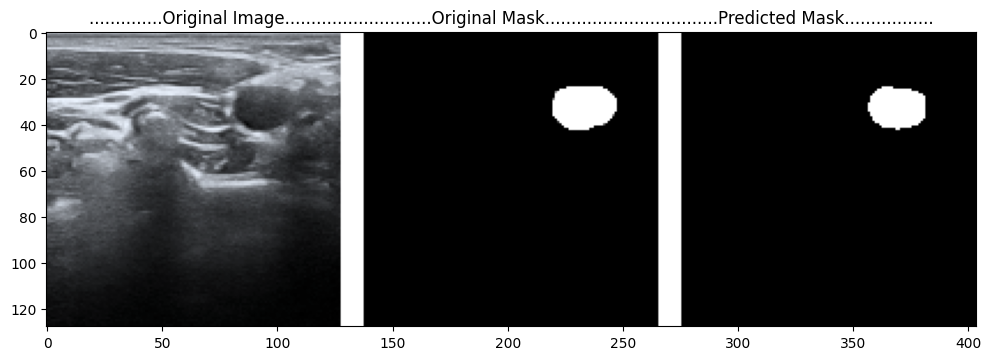

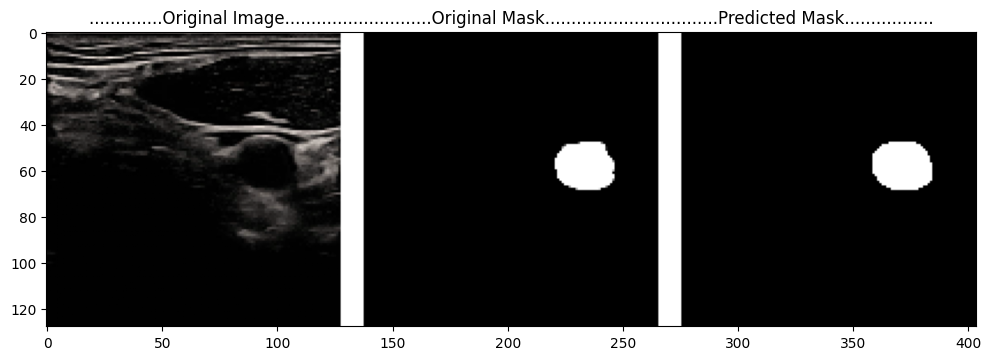

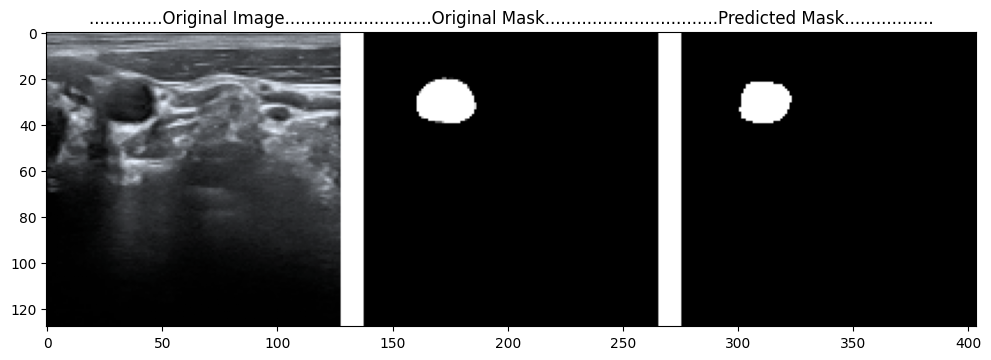

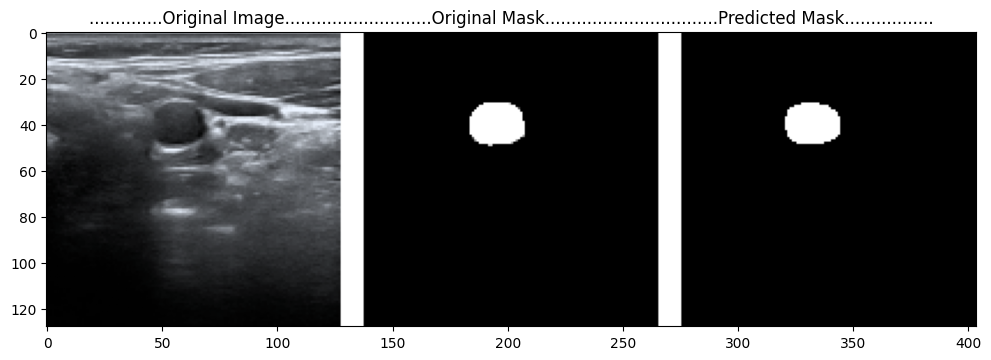

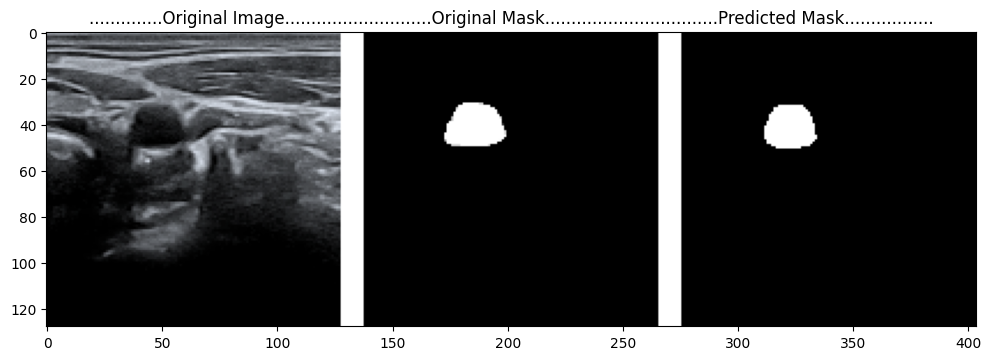

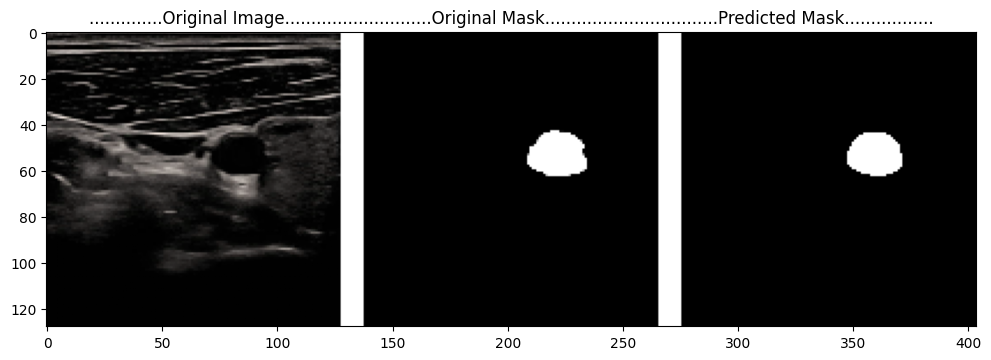

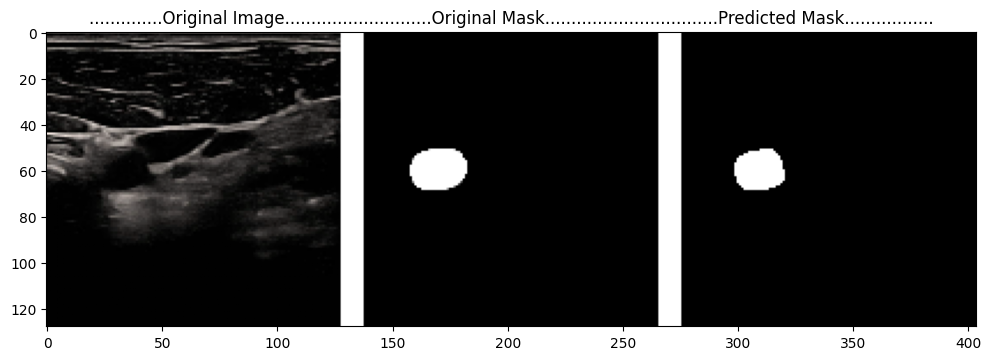

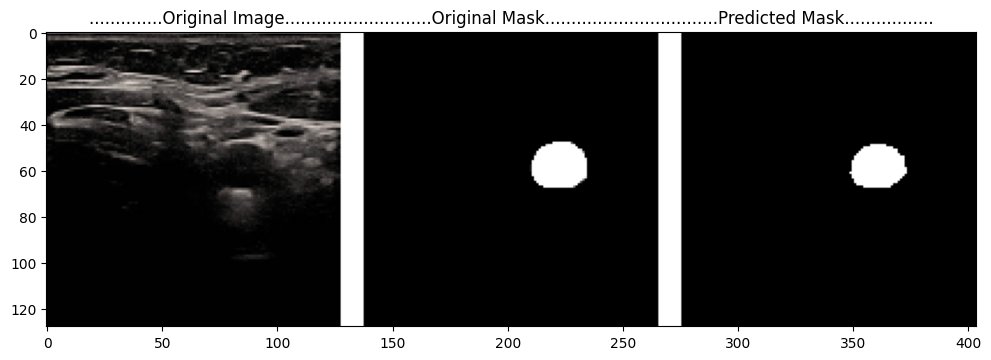

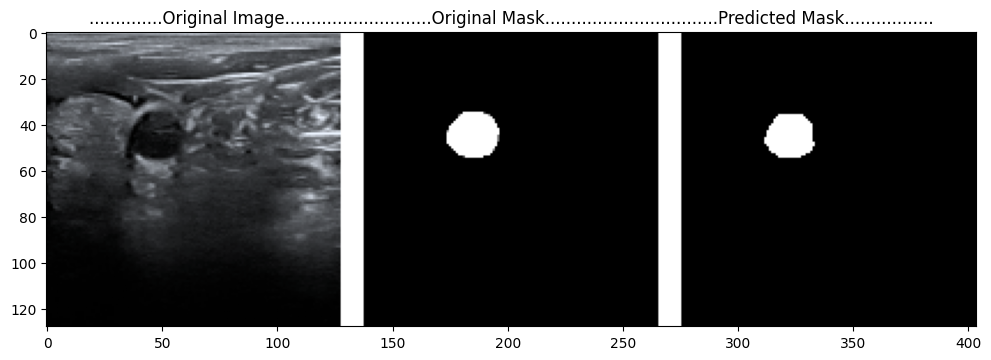

In [23]:
for i, (x, y) in enumerate(zip(test_x[:20], test_y[:20])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    a.set_title("____________Original Image________________________Original Mask_________________________Predicted Mask________________")
    a.set_title("..............Original Image............................Original Mask.................................Predicted Mask.................")
    imgplot = plt.imshow(image)